# ML Boot Camp Lesson 4
Copyright 2019

Author: Paul La Plante

License: BSD 2-clause

# HERA Data
We're now going to transition from the nice, straightforward world of handwritten digits to the Wild, Wild West of Radio Astronomy. Most of our research projects will be dealing with handling HERA data. We're going to briefly talk about what data is contained in HERA data products, and how to work with them. This is only the briefest of overviews necessary to understand what's in a HERA dataset, and there will be resources listed at the end where you can go for more information.

# Radio Astronomy 101
HERA is an _interferometer_, which means that we take the input signals from many input antennas and use the interference patterns to learn about the sky. It's a little counter-intuitive, because HERA does not take pictures of the sky in the traditional sense that we think of when we imagine telescopes. Let's work through a quick-and-dirty discussion of what we're doing when we use an interferometer, and what exactly we save in a HERA dataset.

## From Sky Emission to Visibilities
Let us take the simplest case we can for an interferometer: two antennas pointed at a single source in the sky. The electromagnetic radiation from this source (which can safely be approximated as a plane wave due to the astronomical distances involved) will reach one of the antennas before the second one. This geometrical delay is due entirely to the slightly longer path that the source must take to reach the second antenna compared to the first. See the image below (credit: NRAO):

![Basic Radio Interferometer Setup. Credit: NRAO](images/intblock.png)

In the image, the source is in a direction $\hat{s}$, and the vector connecting the antennas is $\vec{b}$. The geometrical delay $\tau_g$ is then:
$$
\tau_g = \frac{\vec{b} \cdot \hat{s}}{c},
$$
where $c$ is the speed of light. Now, let's suppose we're observing the source at a frequency centerd at $\nu = \omega/(2\pi)$. We can write the output voltages of antennas 1 and 2 $V_1$ and $V_2$ as:
$$
V_1 = A \cos\left[\omega(t - \tau_g)\right],
$$
and
$$
V_2 = A \cos(\omega t),
$$
where $A$ is the amplitude of the signal received in each antenna. If we cross-multiply these two voltages, we have:
$$
V_1 V_2 = A^2 \cos(\omega t)\cos\left[\omega(t-\tau_g)\right] = \left( \frac{A^2}{2} \right)\left[\cos(2\omega t - \omega \tau_g) + \cos(\omega \tau_g)\right].
$$
If we take the time average over a long time ($\Delta t \gg (2\omega)^{-1}$), the rapidly oscillating first term will average to 0, and we'll just be left with the second term:
$$
R \equiv \left \langle V_1 V_2 \right \rangle = \left( \frac{A^2}{2} \right) \cos(\omega \tau_g).
$$
This is the the response of a two-element interferometer observing a point source in the direction $\hat{s}$. If we do not move the antennas to track the source, and instead let the source pass through the part of the sky at which the antennas are pointed, we would end up with the amplitude pattern seen in the figure. The wide Gaussian-like envelope is due to the _primary beam_ of the antenna: the antenna is most sensitive to emission in the direction in which it's pointed, and so the amplitude generally increases and then decreases as the source passes through the point at which the antenna is pointed.

### The Whole Sky
In the example above, we focused on the response of the interferometer to a single point source. If we wanted to get the instantaneous response of the interferometer to _all_ parts of the sky, we treat each point of the sky separately, and sum over all of them by integrating:
$$
R_\mathrm{cos}(\nu) = \int \mathrm{d} \Omega \, I_\nu (\hat{s}) \cos\left(\frac{2 \pi \nu \vec{b} \cdot \hat{s}}{c}\right)
$$
This is the even (cosine) response of the interferometer to the whole sky. Note that implicitly the factor $I_\nu (\hat{s})$ is the product of the intrinsic brightness of the sky in that direction multiplied by the response of the antenna in that direction.

### Complex Visibilities
In the example above, we assumed that the correlator was measuring the even (cosine) component of the incoming radiation. If the signal were not identically even, then we'd lose information by only capturing this component. If we induce a phase shift of $\pi/2$ and perform the time-average of the product of voltages (i.e., compute the correlation), then we'd end up with something proportional to $R_\mathrm{sin} \propto \sin(\omega \tau_g)$, and be sensitive to the odd components of the signal. Using the identity that
$$
e^{i \phi} = \cos(\phi) + i \sin(\phi),
$$
we can rewrite the total complex visibility $V$ as:
$$
V(\nu) \equiv R_\mathrm{cos}(\nu) - i R_\mathrm{sin}(\nu) = \int \mathrm{d}\Omega \, I_\nu(\hat{s}) \exp\left(\frac{-2 \pi i \nu \vec{b} \cdot \hat{s}}{c}\right).
$$
This is known as the radio interferometry measurement equation (RIME), and represents the fundamental quantity that an interferometer is measuring. The visibility is a complex quantity that is a function of frequency, and can change in time. So, we typically record visibilities as complex numbers as a function of frequency $\nu$ and time $t$.

## The Case of HERA
The toy model we saw above is the simplest possible case of an interferometer. Now we'd like to build up to something more complicated. To begin with, if we have multiple antennas, we can treat the signal from the pair as if it were the only one we're looking at. Because we can do this for all such pairs of antennas, for an array of $N$ antennas, we have $N(N-1)/2$ unique baseline combinations. (The factor of two is because the cross-correlation of $V_2 V_1$ is redundant with that of $V_1 V_2$—can you work out why?) We can also record the autocorrelations (the cross-correlation of an antenna with itself), which gives us an additional $N$ measurements. So the total number of complex numbers we have to write down is:
$$
N_\mathrm{tot} = N_\mathrm{ant}\times (N_\mathrm{ant}+1)/2 \times N_\mathrm{frequencies} \times N_\mathrm{times}.
$$
This number can get very large in a hurry! When HERA is fully constructed, we'll have 350 antennas, 6,144 frequency channels, and write out data every two seconds.

### Radio Astronomy: The Biggest Big Data
Quick exercise: what is the projected data rate of HERA when it's fully constructed? Assume that each complex number takes 8 bytes to record (4 bytes each for the real and imaginary components). Give your answer in GB/s. HERA is planning to record 12 hours per night for six months (180 days). What is the total data volume over this period? (The number is actually larger by a factor of 4—there are 4 instrumental polarizations measured as well, which are each recorded separately.)

# Looking at Data from HERA
Now that we've covered the basics of what's in HERA data, let's actually take a look. Remember: a visibility dataset is a complex number defined for an antenna pair $i$ and $j$, frequency $\nu$, and time $t$. Let's read in some data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
uvd = UVData()
uvd.read_uvh5("data/zen.2458432.34569.uvh5")

Before plotting data, let's look at some of the metadata associated with this file. Visibility datasets are mostly the data itself (which can be quite large, as you saw above!), but have essential metadata to help us understand what we're looking at. The full documentation for pyuvdata is avilable on [Read the Docs](https://pyuvdata.readthedocs.io/en/latest/), but here is a crash-course on how to work with the files.

In [2]:
# print some metadata about the dataset
print("Number of frequencies: ", uvd.Nfreqs)
print("Number of times: ", uvd.Ntimes)
print("Number of antennas: ", uvd.Nants_data)
print("Number of polarizations: ", uvd.Npols)

# print out the size of the actual data array
print("Dimensions of data: ", uvd.data_array.shape)

Number of frequencies:  64
Number of times:  8
Number of antennas:  4
Number of polarizations:  4
Dimensions of data:  (80, 1, 64, 4)


## Spectrum Plots
One common way to look at the data from HERA is to look at the instantaneous _spectrum_, which is the visibility at a single moment in time for all frequencies. We can use some of the builtin methods in pyuvdata to get bits of data that we are interested in.

(8, 64, 4)
spectrum shape:  (64,)


Text(0, 0.5, 'Amplitude [Correlator Counts]')

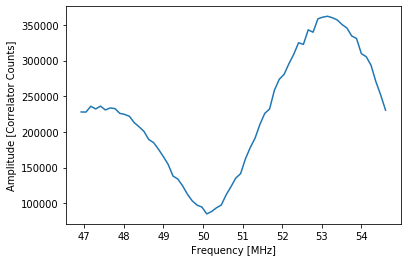

In [3]:
bl01 = uvd.get_data(0, 1)
print(bl01.shape)
spec0 = np.abs(bl01[0, :, 0])
print("spectrum shape: ", spec0.shape)
freqs = uvd.freq_array[0, :] / 1e6  # convert from Hz -> MHz
plt.plot(freqs, spec0)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude [Correlator Counts]")

## Waterfall Plots
One of the most basic ways we visualize HERA data is what we call a _waterfall plot_. This is the complex visibility for a given baseline (pair of antennas), as a function of time and frequency. Let's start by plotting the amplitude and phase of a waterfall. We could also imagine plotting the real and imaginary parts as well, but we'll start with amplitude and phase.